In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [14]:
data = pd.read_csv('~/data/kobe/data.csv')
data = data[data.shot_made_flag.notnull()].reset_index()

In [15]:
data['opponent'] = data.apply(lambda row: 'NOH' if row['season'] == '2004-05' and row['opponent'] == 'NOP' else row['opponent'], axis=1)

In [16]:
defense = pd.read_pickle('./defense_scrape/defense.pkl')
data = data.merge(defense, left_on=['opponent', 'season'], right_on=['Team_Abb', 'Season'], how='left')

In [5]:
def evaluateModel(model):
    print(f'Test Accuracy: {model.score(X_test, y_test):.4f}')
    print(f'Test Log-Loss: {log_loss(y_test, model.predict_proba(X_test)):.4f}')
    print(f'Training Accuracy: {model.score(X_train, y_train):.4f}')

In [6]:
def featureImportance(model):
    feature_importance = list(zip(list(X),model.feature_importances_))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    for f in feature_importance:
        print(f'{f[0]}: {f[1]}')

# Model 1: Random Forest

In [7]:
features = ['period', 'playoffs', 'seconds_remaining', 'minutes_remaining', 'season',
            'shot_distance', 'shot_made_flag', 'shot_zone_area', 'game_date', 'matchup', 
            'action_type', 'Def_Rtg']

dataset = data[features]
dataset['total_seconds_remaining'] = 60*dataset['minutes_remaining'] + dataset['seconds_remaining']
dataset.drop('minutes_remaining', axis=1, inplace=True)
dataset.drop('seconds_remaining', axis=1, inplace=True)
dataset['month'] = dataset['game_date'].map(lambda x: x.split('-')[1])
dataset.drop('game_date', axis=1, inplace=True)
dataset['home'] = dataset['matchup'].str.contains('vs').astype('int')
dataset.drop('matchup', axis=1, inplace=True)
dataset["action_type"] = dataset["action_type"].astype('category')
dataset["period"] = dataset["period"].astype('category')
dataset["playoffs"] = dataset["playoffs"].astype('category')
dataset["season"] = dataset["season"].astype('category')
dataset["shot_made_flag"] = dataset["shot_made_flag"].astype('category')
dataset["month"] = dataset["month"].astype('category')
dataset["home"] = dataset["home"].astype('category')
multi_categorical_features = ['action_type', 'period', 'season', 'month', 'shot_zone_area']
numerical_features = ['total_seconds_remaining', 'shot_distance']
for c in multi_categorical_features:
    dummies = pd.get_dummies(dataset[c], drop_first=True)
    dummies = dummies.add_prefix("{}#".format(c))
    dataset.drop(c, axis=1, inplace=True)
    dataset = dataset.join(dummies)

X = dataset.loc[:, dataset.columns != 'shot_made_flag']
y = dataset['shot_made_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
rf = RandomForestClassifier(n_estimators=200)
grid_params = {'criterion':['entropy'],
               'min_samples_leaf':np.arange(1,20,2)
              }
gs = GridSearchCV(estimator=rf,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)
gs.fit(X_train, y_train)
evaluateModel(gs)
print(f"{gs.best_estimator_}")

In [8]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', min_samples_leaf=9, n_jobs=-1)
rf.fit(X_train, y_train)
evaluateModel(rf)

Test Accuracy: 0.6828
Test Log-Loss: 0.6041
Training Accuracy: 0.6919


In [9]:
featureImportance(rf)

action_type#Jump Shot: 0.20321609616706618
shot_distance: 0.11386497150736619
total_seconds_remaining: 0.09808161877169297
Def_Rtg: 0.0713623545510819
action_type#Layup Shot: 0.06322626656186299
action_type#Driving Layup Shot: 0.040674853837919314
action_type#Slam Dunk Shot: 0.0404806981767149
action_type#Driving Dunk Shot: 0.027660960536047174
action_type#Running Jump Shot: 0.026297858772428427
shot_zone_area#Center(C): 0.023899622569859006
home: 0.022536499560403572
action_type#Jump Bank Shot: 0.013109615641394798
action_type#Pullup Jump shot: 0.011633334524438715
action_type#Turnaround Jump Shot: 0.010572874092785102
period#3: 0.010108278050669247
period#4: 0.00959713473749828
period#2: 0.008327973357111001
month#03: 0.007883921737501255
month#12: 0.007740404651344641
shot_zone_area#Left Side Center(LC): 0.007717783551751834
action_type#Tip Shot: 0.007517934178274926
month#11: 0.007074557682235372
month#02: 0.006854373460821547
action_type#Fadeaway Jump Shot: 0.0067135690355228615
s

# Model 2: Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
features = ['shot_distance', 'shot_made_flag']
X = dataset.loc[:, dataset.columns != 'shot_made_flag']
y = dataset['shot_made_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y)
dataset = data[features]

In [19]:
lr = LogisticRegression(C=10e4)
lr.fit(X_train, y_train)
evaluateModel(lr)

Test Accuracy: 0.6118
Test Log-Loss: 0.6620
Training Accuracy: 0.5928


In [20]:
dist = np.linspace(dataset.shot_distance.min(), dataset.shot_distance.max(), 1000)
probs = lr.predict_proba(X=dist.reshape(-1,1))

In [21]:
thresh = -lr.intercept_/lr.coef_

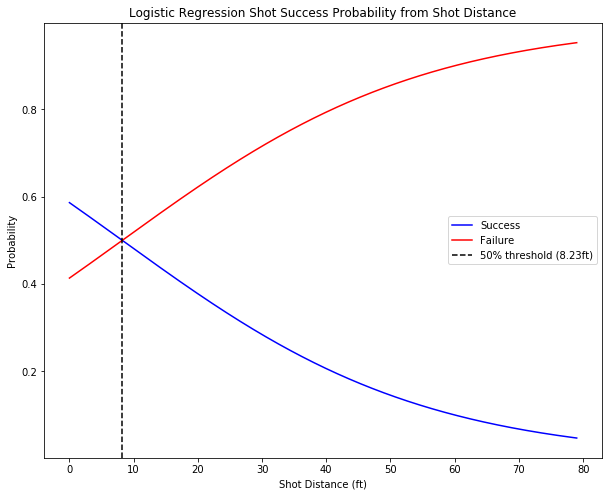

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(dist, probs[:,1], label='Success', color='blue')
ax.plot(dist, probs[:,0], label='Failure', color='red')
ax.axvline(x=thresh, linestyle='--', color='black', label=f'50% threshold ({float(thresh):.2f}ft)')
ax.set_xlabel('Shot Distance (ft)')
ax.set_ylabel('Probability')
ax.legend()
plt.title('Logistic Regression Shot Success Probability from Shot Distance')
plt.show()

## Logistic Regression with the full dataset

In [23]:
features = ['period', 'playoffs', 'seconds_remaining', 'minutes_remaining', 'season',
            'shot_distance', 'shot_made_flag', 'shot_zone_area', 'game_date', 'matchup', 
            'action_type', 'Def_Rtg']

dataset = data[features]
dataset['total_seconds_remaining'] = 60*dataset['minutes_remaining'] + dataset['seconds_remaining']
dataset.drop('minutes_remaining', axis=1, inplace=True)
dataset.drop('seconds_remaining', axis=1, inplace=True)
dataset['month'] = dataset['game_date'].map(lambda x: x.split('-')[1])
dataset.drop('game_date', axis=1, inplace=True)
dataset['home'] = dataset['matchup'].str.contains('vs').astype('int')
dataset.drop('matchup', axis=1, inplace=True)
dataset["action_type"] = dataset["action_type"].astype('category')
dataset["period"] = dataset["period"].astype('category')
dataset["playoffs"] = dataset["playoffs"].astype('category')
dataset["season"] = dataset["season"].astype('category')
dataset["shot_made_flag"] = dataset["shot_made_flag"].astype('category')
dataset["month"] = dataset["month"].astype('category')
dataset["home"] = dataset["home"].astype('category')
multi_categorical_features = ['action_type', 'period', 'season', 'month', 'shot_zone_area']
numerical_features = ['total_seconds_remaining', 'shot_distance']
for c in multi_categorical_features:
    dummies = pd.get_dummies(dataset[c], drop_first=True)
    dummies = dummies.add_prefix("{}#".format(c))
    dataset.drop(c, axis=1, inplace=True)
    dataset = dataset.join(dummies)

X = dataset.loc[:, dataset.columns != 'shot_made_flag']
y = dataset['shot_made_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
lr = LogisticRegression(C=10e4)
lr.fit(X_train, y_train)
evaluateModel(lr)

Test Accuracy: 0.6819
Test Log-Loss: 0.6109
Training Accuracy: 0.6832


In [25]:
lr = LogisticRegression(C=0.5,penalty='l1')
lr.fit(X_train, y_train)
evaluateModel(lr)

Test Accuracy: 0.6822
Test Log-Loss: 0.6103
Training Accuracy: 0.6824
